<a href="https://colab.research.google.com/github/LNickelsburg/clusterify/blob/main/clusterify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

## prep the dataset

In [207]:
columns=['id','users','title','artist',
         'release_date','acousticness','danceability','duration_ms','energy',
         'explicit','instrumentalness','key','liveness','loudness','popularity',
         'mode','speechiness','tempo','time_signature','valence']

In [208]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/spotify_app/dataset.csv',
                    usecols=columns)

In [209]:
# get rid of empty columns (for if one of the api calls didnt work right)
dataset = dataset.dropna(axis=1, how='all')

# get rid of rows missing information
dataset = dataset.dropna(axis=0, how='any')

In [210]:
# turn release date into year integer
for i, date in enumerate(dataset['release_date']):
    date = int(date[:4])
    dataset.loc[i, 'release_date'] = date

In [211]:
# split into features, user labels, and title/artist labels

variables=[#'release_date',
           'acousticness',
           'danceability',
           'duration_ms',
           'energy',
           #'explicit',
           'instrumentalness',
           #'key',
           'liveness',
           'loudness',
           'popularity',
           #'mode',
           'speechiness',
           'tempo',
           #'time_signature',
           'valence']

features = dataset[variables]
users = dataset['users']
titles = dataset['title']
artists = dataset['artist']

In [212]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [213]:
flattened_users = []
for user in users:
    user_list = user.split(',')
    flattened_users.extend([u.strip("'") for u in user_list])

unique_users = np.unique(flattened_users)

In [214]:
# give the users all their own colors :)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_users)))
user_colors = dict(zip(unique_users, colors))
print(user_colors)

{'Brendan Sweezy': array([0.5, 0. , 1. , 1. ]), 'Justin': array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 'Leah': array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])}


In [215]:
# if you wanna personalize the colors

user_colors['Brendan Sweezy'] = 'purple'
user_colors['Justin'] = 'yellow'
user_colors['Leah'] = 'lightblue'

## distribution visualization (just for funsies)

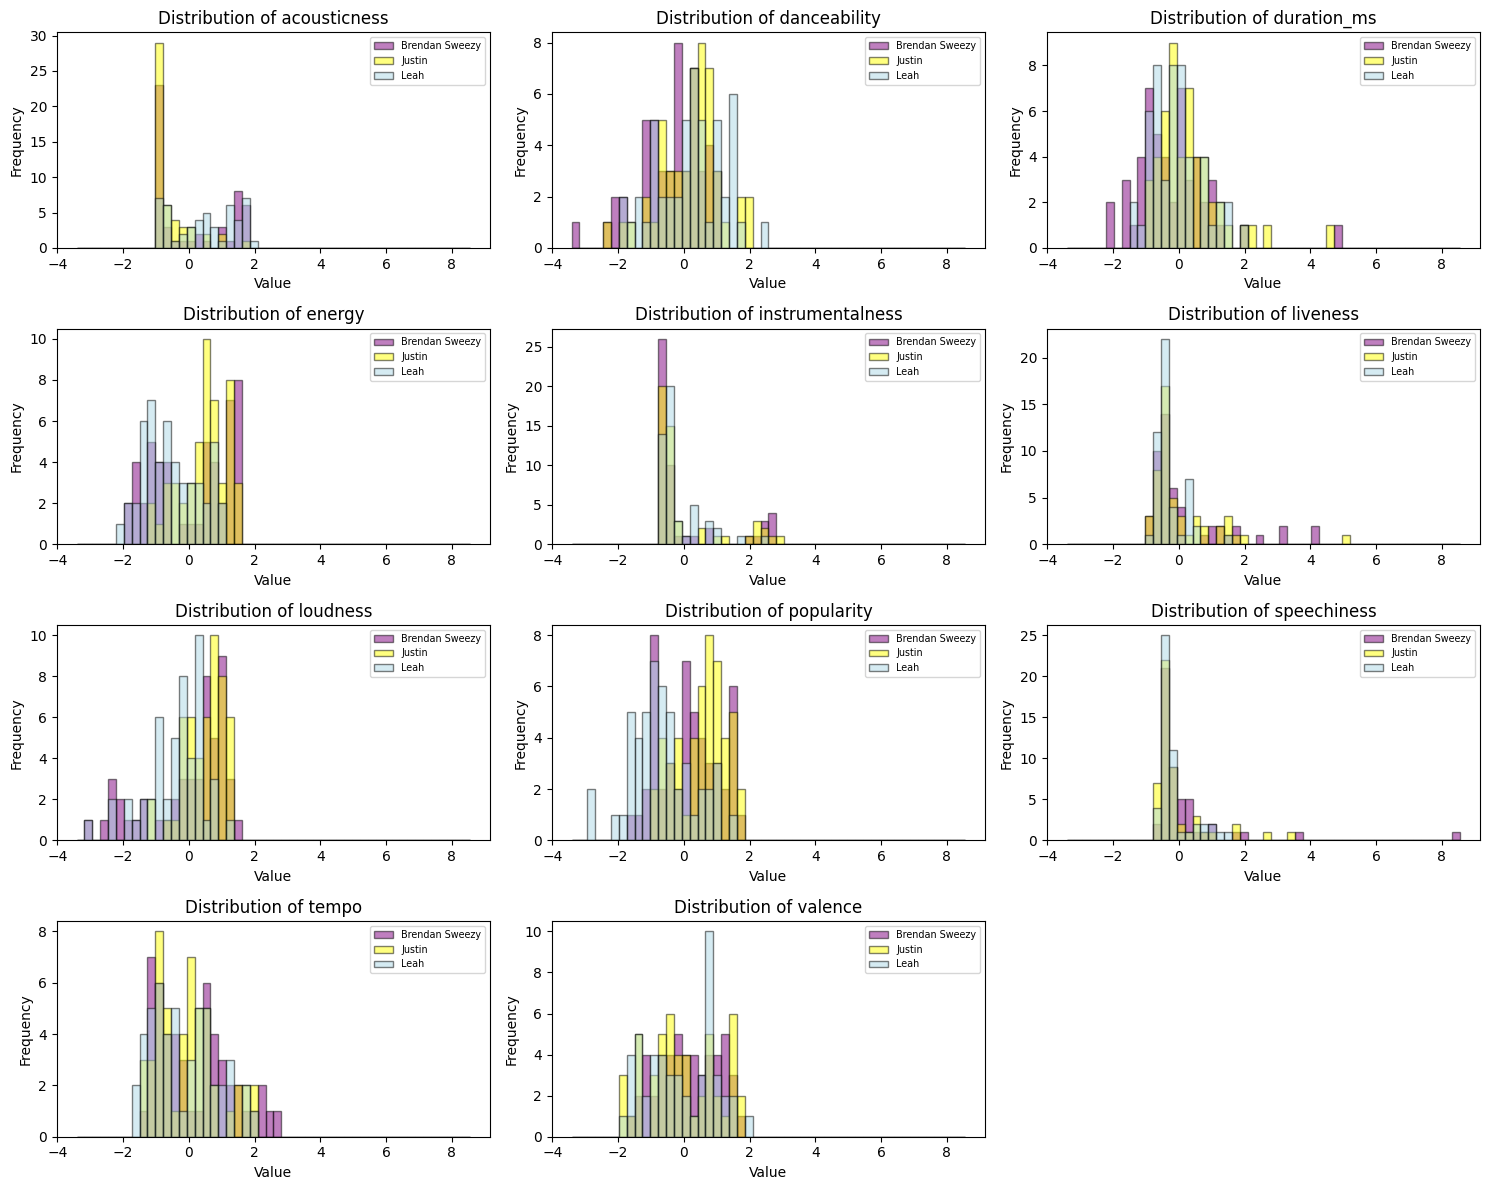

In [216]:
# distribution

feature_names = features.columns
num_features = scaled_features.shape[1]

ncols = 3
nrows = (num_features+2)//ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
axes = axes.ravel()

min_feature_value = np.min(scaled_features)
max_feature_value = np.max(scaled_features)
num_bins=50
bins = np.linspace(min_feature_value, max_feature_value, num_bins + 1)

# Plot histograms for each feature
for i in range(num_features):
    ax = axes[i]
    for user_index, user in enumerate(unique_users):
      #if user != "Justin":
        # Mask to select only the rows for the current user
        user_mask = np.array(users) == user
        user_features = scaled_features[user_mask, i]

        # Plot histogram for the current user and feature
        ax.hist(user_features, bins=bins, color=user_colors[user], alpha=0.5,
                edgecolor='black',label=user)

    ax.set_title(f'Distribution of {feature_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper right', fontsize='x-small')

# Hide any unused axes
for i in range(num_features, nrows * 3):
    fig.delaxes(axes[i])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# K-Means and PCA

In [217]:
!pip install plotly
import plotly.graph_objects as go

In [218]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, n_init=1000)  # Choose the number of clusters
kmeans.fit(scaled_features)
labels = kmeans.labels_


In [219]:
# Dimensionality Reduction for Visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(scaled_features)


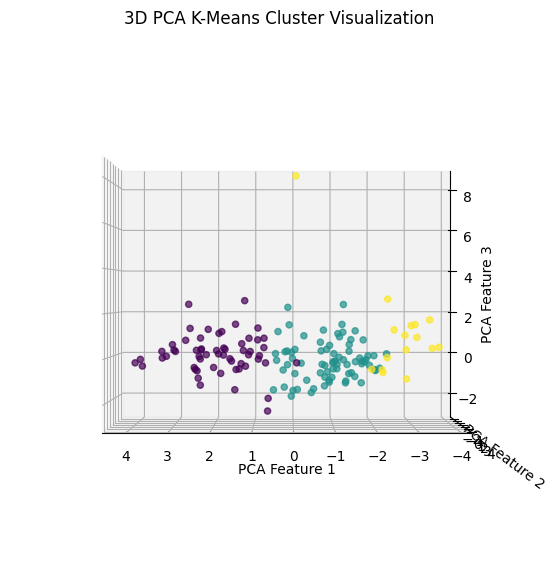

In [220]:
# plot, with colors representing k-means clusters
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels, alpha=0.7)

ax.view_init(elev=0, azim=90)
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
ax.set_title('3D PCA K-Means Cluster Visualization')

plt.show()

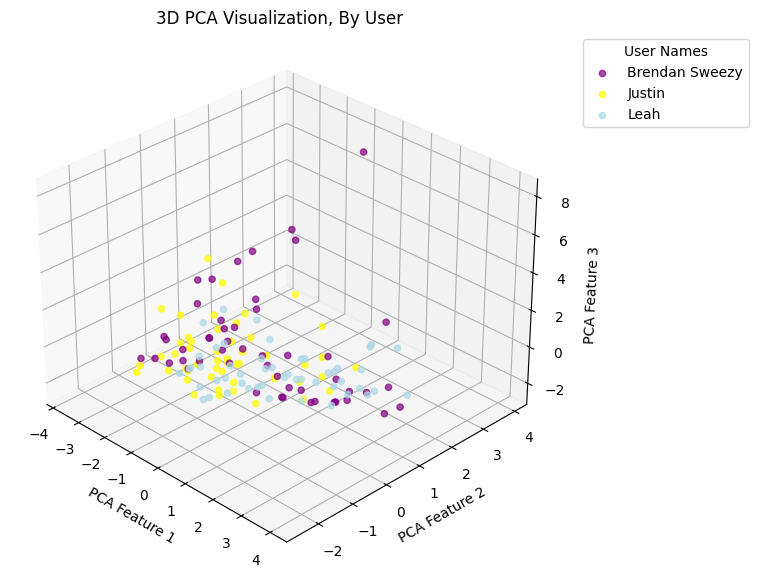

In [221]:
# plot, with colors representing users
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')

for user_index, user in enumerate(unique_users):
    user_mask = np.array(users) == user  # Create a mask for the current user
    user_features = reduced_features[user_mask]  # Apply mask to features

    # Use the mask to plot only this user's features
    ax.scatter(user_features[:, 0], user_features[:, 1], user_features[:, 2], color=user_colors[user], label=user, alpha=0.7)

ax.view_init(elev=30, azim=-45)
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
ax.set_title('3D PCA Visualization, By User')

# Create a legend
plt.legend(title="User Names", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [222]:

fig = go.Figure()

for user_index, user in enumerate(unique_users):
    user_mask = np.array(users) == user  # Create a mask for the current user
    user_features = reduced_features[user_mask]  # Apply mask to features

    track_info = dataset[user_mask]
    infos = list(zip(track_info.index, track_info.artist, track_info.title))

    # Add a scatter plot for each user
    fig.add_trace(go.Scatter3d(
        x=user_features[:, 0],
        y=user_features[:, 1],
        z=user_features[:, 2],
        mode='markers',
        marker=dict(
            color=user_colors[user],
            opacity=0.7
        ),
        name=user,
        customdata=infos,

        hovertemplate="ID: %{customdata[0]}<br>Artist: %{customdata[1]}<br>Title: %{customdata[2]}"
    ))

# Update layout
fig.update_layout(
    title='3D PCA Visualization, By User',
    scene=dict(
        xaxis_title='PCA Feature 1',
        yaxis_title='PCA Feature 2',
        zaxis_title='PCA Feature 3'
    ),
    legend_title="User Names"
)

fig.show()

# PCA

In [223]:
principal_components = pd.DataFrame(data=reduced_features, columns=['PC1', 'PC2', 'PC3'])

explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component: {explained_variance}")


loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=features.columns)
print(loading_matrix)

Explained variance by component: [0.30060194 0.12862524 0.1182647 ]
                       PC1       PC2       PC3
acousticness      0.843168  0.082849  0.282598
danceability      0.257197 -0.721630  0.347175
duration_ms      -0.008760  0.221846 -0.191400
energy           -0.932183 -0.128586 -0.146196
instrumentalness  0.378700  0.153176 -0.273515
liveness         -0.394665  0.418264  0.483118
loudness         -0.876401 -0.184392 -0.055842
popularity       -0.494202  0.034768 -0.248805
speechiness      -0.179241  0.300753  0.717530
tempo            -0.391792  0.509800  0.125517
valence          -0.430780 -0.497036  0.383932


In [224]:
ranked_PC1 = loading_matrix.sort_values(by='PC1', ascending=False)
ranked_PC2 = loading_matrix.sort_values(by='PC2', ascending=False)
ranked_PC3 = loading_matrix.sort_values(by='PC3', ascending=False)


print("Features sorted by their impact on PC1:")
print(ranked_PC1['PC1'])

print("\nFeatures sorted by their impact on PC2:")
print(ranked_PC2['PC2'])

print("\nFeatures sorted by their impact on PC3:")
print(ranked_PC3['PC3'])

Features sorted by their impact on PC1:
acousticness        0.843168
instrumentalness    0.378700
danceability        0.257197
duration_ms        -0.008760
speechiness        -0.179241
tempo              -0.391792
liveness           -0.394665
valence            -0.430780
popularity         -0.494202
loudness           -0.876401
energy             -0.932183
Name: PC1, dtype: float64

Features sorted by their impact on PC2:
tempo               0.509800
liveness            0.418264
speechiness         0.300753
duration_ms         0.221846
instrumentalness    0.153176
acousticness        0.082849
popularity          0.034768
energy             -0.128586
loudness           -0.184392
valence            -0.497036
danceability       -0.721630
Name: PC2, dtype: float64

Features sorted by their impact on PC3:
speechiness         0.717530
liveness            0.483118
valence             0.383932
danceability        0.347175
acousticness        0.282598
tempo               0.125517
loudness      

In [225]:
print(scaled_features)

[[-0.87589139  0.21468061 -0.48858502 ... -0.24702515 -0.98200304
   1.08593034]
 [ 0.31946932  0.3199185   1.41475183 ... -0.38233871  0.78468186
  -0.86378806]
 [ 1.16423701  0.10242687  0.23447933 ... -0.43154364 -0.76698766
  -0.35997427]
 ...
 [ 0.65103343 -0.13611234 -0.01552266 ... -0.3183723  -1.03801913
  -0.08963516]
 [ 1.66302476  0.69175903 -0.26231157 ...  0.0359032  -0.68051556
  -1.07678251]
 [-0.93977947 -1.2586498  -0.01371247 ... -0.32329279 -1.05895342
   0.84426357]]


In [234]:
#im gonna manually mess with the features

feature_x = [1]
feature_y = [3]
feature_z = [6]


# Creating new components by averaging selected features using their indices
x = scaled_features[:, feature_x].mean(axis=1)
y = scaled_features[:, feature_y].mean(axis=1)
z = scaled_features[:, feature_z].mean(axis=1)

# Combine into a NumPy array or a DataFrame
principal_components = np.column_stack((x, y, z))
scaler = StandardScaler()
principal_components = scaler.fit_transform(principal_components)

In [236]:

fig = go.Figure()

for user_index, user in enumerate(unique_users):
    user_mask = np.array(users) == user  # Create a mask for the current user
    user_features = principal_components[user_mask]  # Use new principal components

    track_info = dataset[user_mask]
    infos = list(zip(track_info.index, track_info.artist, track_info.title))

    # Add a scatter plot for each user
    fig.add_trace(go.Scatter3d(
        x=user_features[:, 0],  # Assuming PC1 is in the first column
        y=user_features[:, 1],  # Assuming PC2 is in the second column
        z=user_features[:, 2],  # Assuming PC3 is in the third column
        mode='markers',
        marker=dict(
            color=user_colors[user],
            opacity=0.7
        ),
        name=user,
        customdata=infos,
        hovertemplate="ID: %{customdata[0]}<br>Artist: %{customdata[1]}<br>Title: %{customdata[2]}"
    ))

# Update layout
fig.update_layout(
    title='3D PCA Visualization, By User',
    scene=dict(
        xaxis_title='danceability',
        yaxis_title='energy',
        zaxis_title='loudness'
    ),
    legend_title="User Names"
)

fig.show()